In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [2]:
# limit GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

def reset_session():
    K.get_session().close()
    K.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
train_path = 'sampled_photos/train'
valid_path = 'sampled_photos/val'

# create image data generators to feed the model from image directories
target_size = (224, 224)
batch_size = 8
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=target_size, 
                                                         batch_size=batch_size)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=target_size,
                                                         batch_size=batch_size)

Found 9000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [4]:
def build_VGG16(width, new_weights=False, trainable=False, learning_rate=0.0001):
    '''
    Builds a modified version of the VGG16 model for transfer learning
    
    Parameters:
    width(int) - number of nodes present in each of the two new FC layers after
        the convolutional layers
    new_weights(bool) - whether to reinitialize the weights in the VGG16
        convolutional layers
    trainable(bool) - whether to allow updating of convolutional weights
    
    Returns:
    Compiled keras functional API model object
    '''
    
    if new_weights == True:
        weights = None
    else:
        weights = 'imagenet'
    
    # import only the convolutional layers of VGG16
    base_model = VGG16(include_top=False, 
                       weights=weights, 
                       input_shape=(224, 224, 3))
    
    if trainable == False:
        for layer in base_model.layers:
            layer.trainable = False
    
    # add two FC layers to end of convolutional layers
    inputs = base_model.output
    x = Flatten()(inputs)
    x = Dense(width, activation='relu')(x)
    x = Dense(width, activation='relu')(x)
    preds = Dense(5, activation='softmax')(x)

    # compile model
    model = Model(inputs=base_model.inputs, outputs=preds)
    model.compile(optimizer=Adam(lr=learning_rate, decay=0.1), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [5]:
def run_in_duplicate(width, n_epochs=10, new_weights=False, trainable=False, learning_rate=0.0001):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history
    '''
    from datetime import datetime
    
    filename = 'vgg16_lr_{}_'.format(str(learning_rate).replace('.', '-'))
    
    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('{} - Starting training for {}'.format(datetime_now, filename + '1'))
    
    # define callbacks for model fitting
    checkpointer = ModelCheckpoint(filename + '1.h5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True)
    
    # build first model
    model_1 = build_VGG16(width, new_weights=new_weights, trainable=trainable, learning_rate=learning_rate)
    
    # fit the model to the training data
    history_1 = model_1.fit_generator(train_batches, 
                                      steps_per_epoch=9000/batch_size, 
                                      validation_data=valid_batches, 
                                      validation_steps=1000/batch_size, 
                                      epochs=n_epochs, 
                                      callbacks=[checkpointer], 
                                      verbose=0)
    
    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('{} - Starting training for {}'.format(datetime_now, filename + '2'))
    
    checkpointer = ModelCheckpoint(filename + '2.h5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True)
    
    # build second model
    model_2 = build_VGG16(width, new_weights=new_weights, trainable=trainable, learning_rate=learning_rate)
    
    # fit the model to the training data
    history_2 = model_2.fit_generator(train_batches, 
                                      steps_per_epoch=9000/batch_size, 
                                      validation_data=valid_batches, 
                                      validation_steps=1000/batch_size, 
                                      epochs=n_epochs, 
                                      callbacks=[checkpointer], 
                                      verbose=0)
    
    def avg_metric(metric):
        metric_1 = np.array(history_1.history[metric])
        metric_2 = np.array(history_2.history[metric])
        return (metric_1 + metric_2)/2
    
    # determine average metrics of the two runs
    acc = avg_metric('acc')
    loss = avg_metric('loss')
    val_acc = avg_metric('val_acc')
    val_loss = avg_metric('val_loss')
    
    # plot loss history
    plot_df = tuple([loss, val_loss])
    plot_df = np.column_stack(plot_df)
    plot_df = pd.DataFrame(plot_df, columns=('training', 'validation'))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_df.plot(ax=ax)
    plt.title('Loss over epochs: {}'.format(filename))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, len(loss)))
    plt.legend(loc='upper right')
    plt.show()
    
    return {'acc': acc, 'loss':loss, 'val_acc':val_acc, 'val_loss':val_loss}

2018-08-27 21:50:53 - Starting training for vgg16_lr_0-001_1
2018-08-27 23:11:36 - Starting training for vgg16_lr_0-001_2


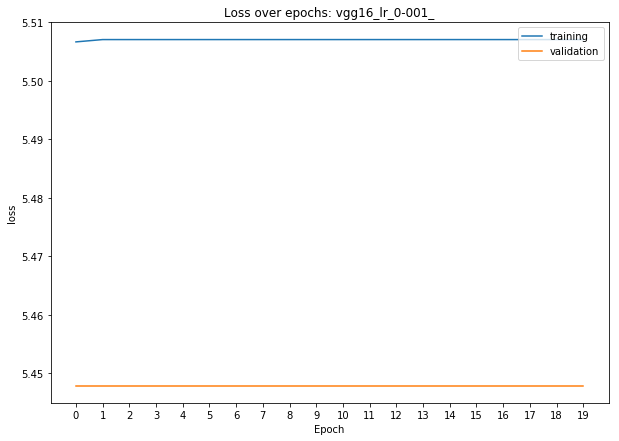

2018-08-28 00:31:08 - Starting training for vgg16_lr_0-0005_1
2018-08-28 01:52:13 - Starting training for vgg16_lr_0-0005_2


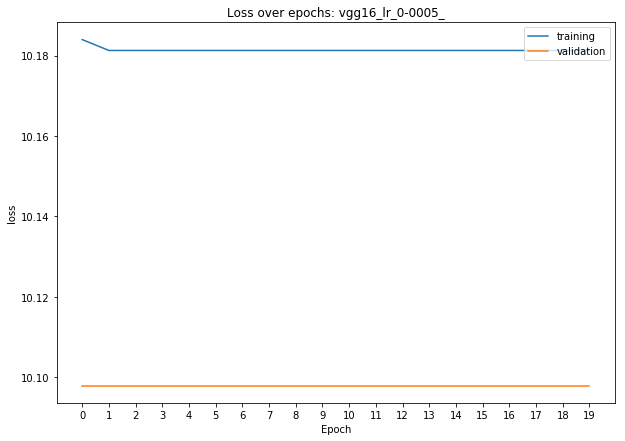

2018-08-28 03:11:59 - Starting training for vgg16_lr_0-0001_1
2018-08-28 04:32:01 - Starting training for vgg16_lr_0-0001_2


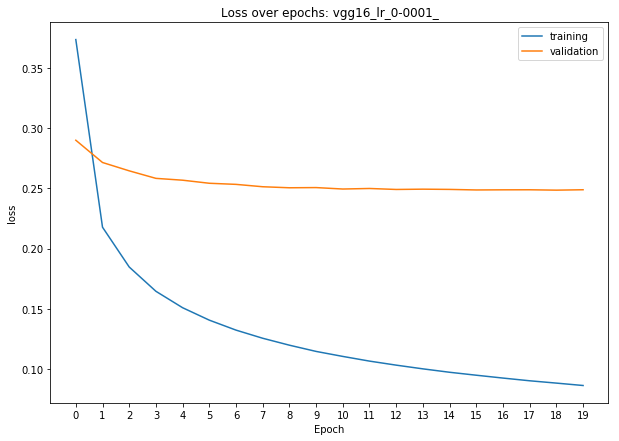

2018-08-28 05:52:07 - Starting training for vgg16_lr_5e-05_1
2018-08-28 07:12:16 - Starting training for vgg16_lr_5e-05_2


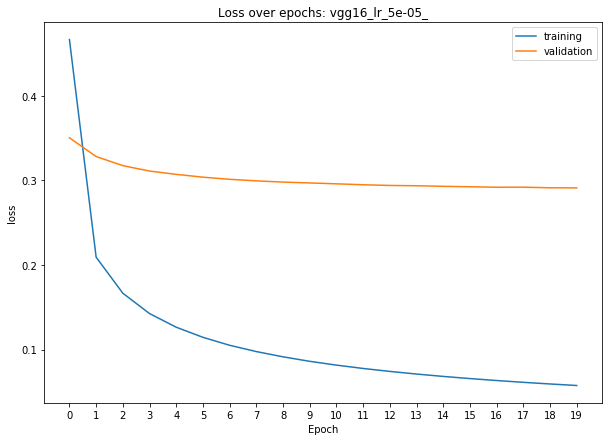

2018-08-28 08:32:51 - Starting training for vgg16_lr_1e-05_1
2018-08-28 09:53:05 - Starting training for vgg16_lr_1e-05_2


KeyboardInterrupt: 

In [6]:
# test different learning rates for model
rates = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

histories = dict()

for rate in rates:
    histories[rate] = run_in_duplicate(width=800, n_epochs=20, new_weights=False, trainable=True, learning_rate=rate)

reset_session()

In [8]:
K.get_session().close()

2018-08-28 18:32:04 - Starting training for vgg16_lr_1e-05_1
2018-08-28 19:53:07 - Starting training for vgg16_lr_1e-05_2


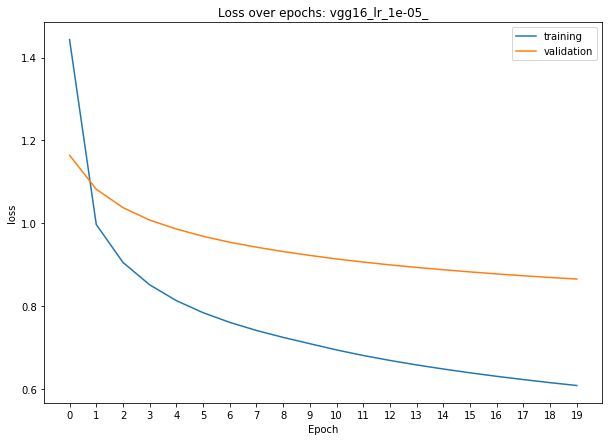

In [6]:
# load histories
histories = pd.read_json('VGG16_learnrate_comparison_history.json', convert_axes=False).transpose()

# rerun last condition and add to history
history = run_in_duplicate(width=600, n_epochs=20, new_weights=False, trainable=True, learning_rate=0.00001)

In [25]:
# load histories
histories = pd.read_json('VGG16_learnrate_comparison_history.json', convert_axes=False).transpose()
histories

,0.00001,0.00005,0.0001
acc,acc,"[0.8700555556, 0.9335, 0.9482777778, 0.9562222...","[0.8875000000000001, 0.9257777778, 0.9365, 0.9..."
loss,loss,"[0.4666569245, 0.2092030527, 0.1665932806, 0.1...","[0.3736501131, 0.2177322939, 0.1846553085, 0.1..."
val_acc,val_acc,"[0.891, 0.896, 0.8995000000000001, 0.904500000...","[0.9075000000000001, 0.9125000000000001, 0.917..."
val_loss,val_loss,"[0.3504745495, 0.3282947483, 0.3175205604, 0.3...","[0.2900064073, 0.2715007702, 0.2645731816, 0.2..."


In [26]:
histories['0.00001'] = history.values()
histories

,0.00001,0.00005,0.0001
acc,"(0.7952222222222223, 0.8412222222222222, 0.850...","[0.8700555556, 0.9335, 0.9482777778, 0.9562222...","[0.8875000000000001, 0.9257777778, 0.9365, 0.9..."
loss,"(1.443360270606226, 0.9971088036990154, 0.9055...","[0.4666569245, 0.2092030527, 0.1665932806, 0.1...","[0.3736501131, 0.2177322939, 0.1846553085, 0.1..."
val_acc,"(0.812, 0.817, 0.8200000000000001, 0.8225, 0.8...","[0.891, 0.896, 0.8995000000000001, 0.904500000...","[0.9075000000000001, 0.9125000000000001, 0.917..."
val_loss,"(1.1642584791497792, 1.0821691808785667, 1.037...","[0.3504745495, 0.3282947483, 0.3175205604, 0.3...","[0.2900064073, 0.2715007702, 0.2645731816, 0.2..."


In [27]:
# save history as json
pd.DataFrame(histories).transpose().to_json('VGG16_learnrate_comparison_history.json')

                                                       acc  \
0.00001  [0.7952222222, 0.8412222222, 0.8504444444, 0.8...   
0.00005  [0.8700555556, 0.9335, 0.9482777778, 0.9562222...   
0.0001   [0.8875000000000001, 0.9257777778, 0.9365, 0.9...   

                                                      loss  \
0.00001  [1.4433602706, 0.9971088037, 0.9055712855, 0.8...   
0.00005  [0.4666569245, 0.2092030527, 0.1665932806, 0.1...   
0.0001   [0.3736501131, 0.2177322939, 0.1846553085, 0.1...   

                                                   val_acc  \
0.00001  [0.812, 0.8170000000000001, 0.8200000000000001...   
0.00005  [0.891, 0.896, 0.8995000000000001, 0.904500000...   
0.0001   [0.9075000000000001, 0.9125000000000001, 0.917...   

                                                  val_loss  
0.00001  [1.1642584791, 1.0821691809, 1.0378301452, 1.0...  
0.00005  [0.3504745495, 0.3282947483, 0.3175205604, 0.3...  
0.0001   [0.2900064073, 0.2715007702, 0.2645731816, 0.2...  


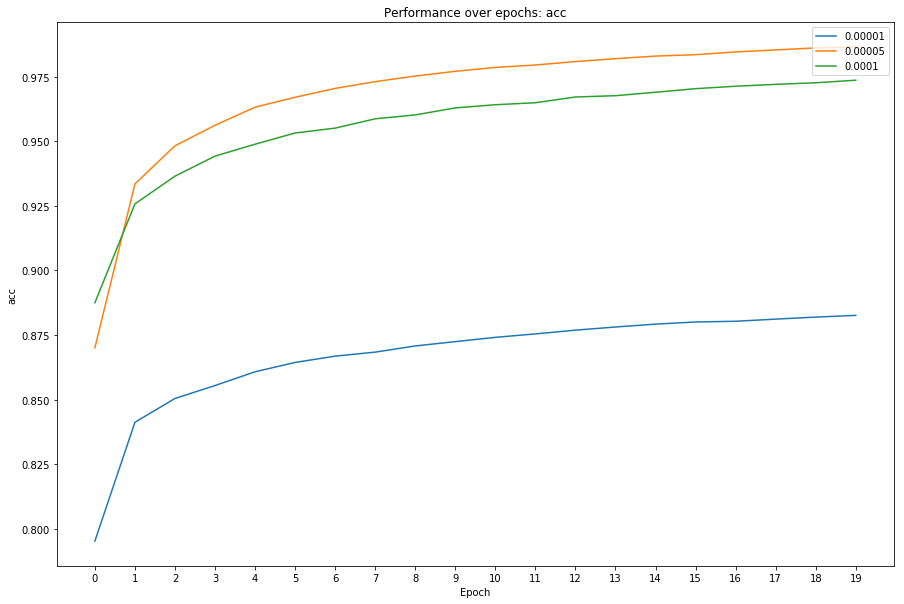

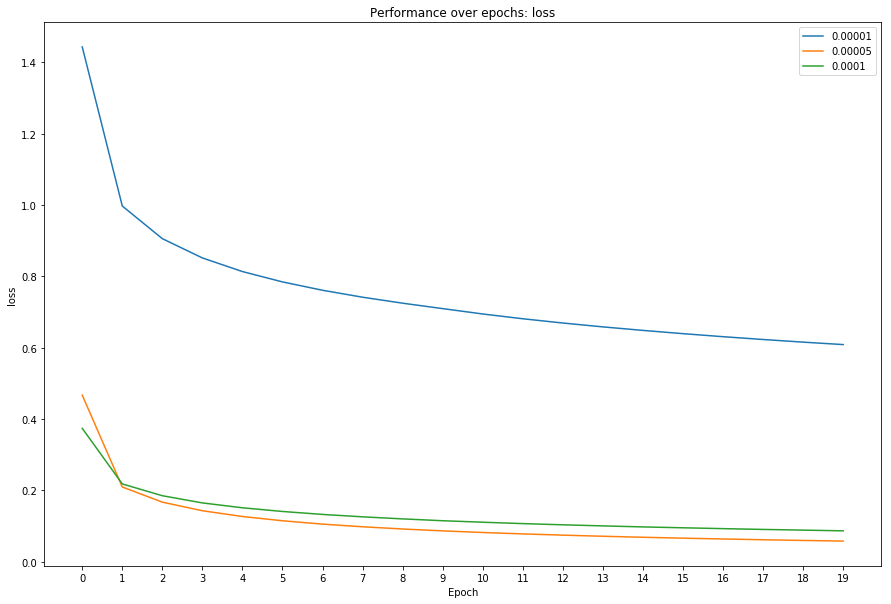

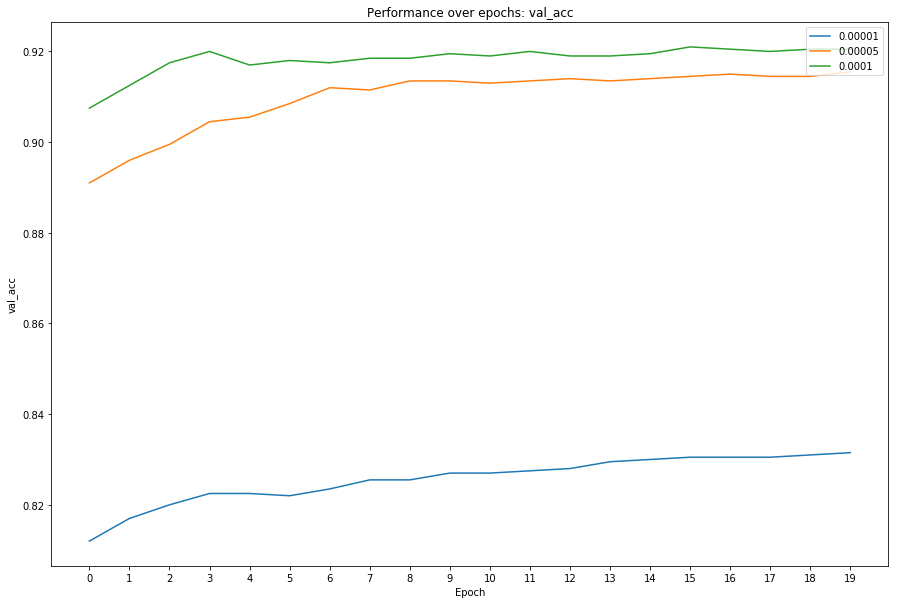

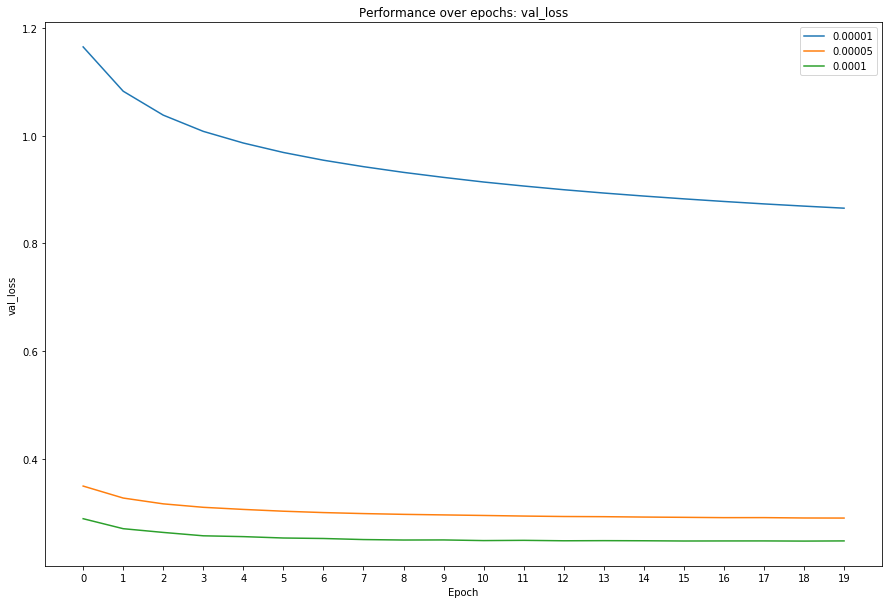

In [28]:
def plot_metric(metric, histories):
    # extract metric of interest
    hist_df = pd.DataFrame()
    for i, history in histories.iterrows():
        hist_df[i] = history[metric]

    # plot history
    fig, ax = plt.subplots(figsize=(15, 10))
    hist_df.plot(ax=ax)
    plt.title('Performance over epochs: {}'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.xticks(range(0, len(hist_df.iloc[:, 1])))
    plt.legend(loc='upper right')
    plt.show()

# load history from json
histories_load = pd.read_json('VGG16_learnrate_comparison_history.json', convert_axes=False)
print(histories_load)

# drop conditions that didn't converge
# histories.drop(['0.001', '0.0005'], inplace=True)
    
plot_metric('acc', histories_load)
plot_metric('loss', histories_load)
plot_metric('val_acc', histories_load)
plot_metric('val_loss', histories_load)

In [11]:
histories


,0.00001,0.00005,0.0001
acc,acc,"[0.8700555556, 0.9335, 0.9482777778, 0.9562222...","[0.8875000000000001, 0.9257777778, 0.9365, 0.9..."
loss,loss,"[0.4666569245, 0.2092030527, 0.1665932806, 0.1...","[0.3736501131, 0.2177322939, 0.1846553085, 0.1..."
val_acc,val_acc,"[0.891, 0.896, 0.8995000000000001, 0.904500000...","[0.9075000000000001, 0.9125000000000001, 0.917..."
val_loss,val_loss,"[0.3504745495, 0.3282947483, 0.3175205604, 0.3...","[0.2900064073, 0.2715007702, 0.2645731816, 0.2..."
